This notebook is a copy of **"Jantahack:Independence Day ML hackathons"**. You can find the dataset and main copy of this notebook on this [link](https://www.kaggle.com/chandankumarroy/topic-modeling-and-multiclass-classifier/notebook)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# plt.style.use('g')
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/labels.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/vocab.txt
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_model.ckpt.index
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_config.json
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001


In [2]:
train_df = pd.read_csv("../input/janatahack-independence-day-2020-ml-hackathon/train.csv")
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [3]:
train_df.shape

(20972, 9)

In [4]:
test_df = pd.read_csv("../input/janatahack-independence-day-2020-ml-hackathon/test.csv")
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [5]:
test_df.shape

(8989, 3)

In [6]:
sample_df = pd.read_csv("../input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv")
sample_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,0
1,20974,0,0,0,0,0,0
2,20975,0,0,0,0,0,0
3,20976,0,0,0,0,0,0
4,20977,0,0,0,0,0,0


In [7]:
test_id = test_df.ID.values
test_id

array([20973, 20974, 20975, ..., 29959, 29960, 29961])

## Exploratory data analysis

In [8]:
plt.style.use('ggplot')

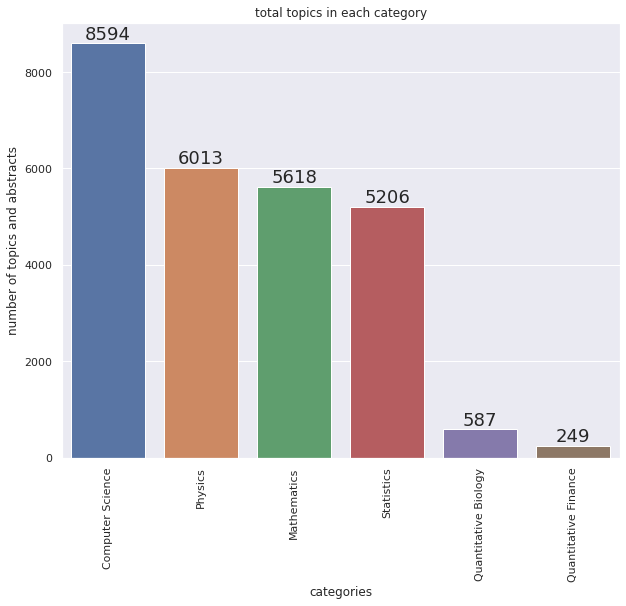

In [9]:
categories = list(train_df.columns.values)[3:]
values = list(train_df.iloc[:,3:].sum(axis =0).values)

sns.set(font_scale =1)
fig = plt.figure(figsize =(10,8))

ax = sns.barplot(categories,values)
ax.set_xlabel("categories")
ax.set_ylabel("number of topics and abstracts")
ax.set_title("total topics in each category")
plt.xticks(rotation=90)


rects = ax.patches
labels = values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    
plt.show()

In [10]:
from wordcloud import WordCloud, STOPWORDS

### Let's visualize the word cloud for Computer Sciecne category

In [11]:
subset = train_df[train_df['Computer Science'] == True]
subset = subset.TITLE.values

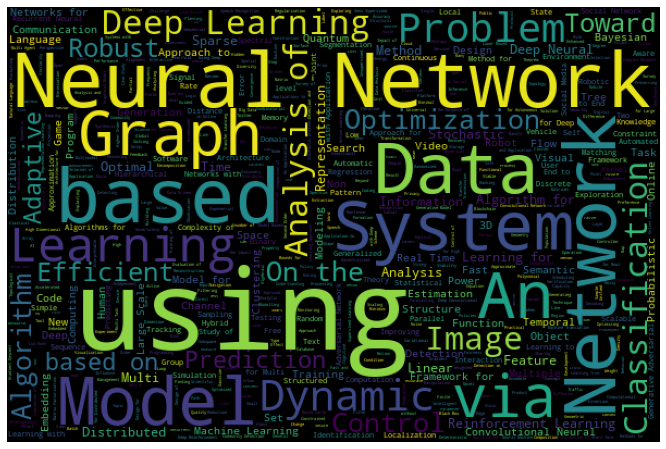

In [12]:
stopwords = set(STOPWORDS)
cse_wc = WordCloud(
            background_color='black',
            max_words=3000,
            stopwords= stopwords,
            width =600,height = 400).generate(" ".join(subset))

fig  = plt.figure(figsize=(14,8))
plt.imshow(cse_wc)
plt.axis('off')
plt.show()

# Data Preprocessing 

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import warnings
import sys

data_train = train_df.copy()
data_test = test_df.copy()


data_train['TITLE'] = data_train[['TITLE','ABSTRACT']].apply(lambda x: " ".join(x),axis =1)
data_test['TITLE'] = data_test[['TITLE','ABSTRACT']].apply(lambda x: " ".join(x),axis =1)

del data_train['ABSTRACT']
del data_test['ABSTRACT']


if not sys.warnoptions:
    warnings.simplefilter("ignore")
        
        

In [14]:
data_train.columns.values

array(['ID', 'TITLE', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype=object)

In [15]:
def cleanPunctuation(sentence):
    cl_sentence  = re.sub(r'[?|!|\'|"|#|\_]',r'',sentence)
    cl_sentence = re.sub(r'[.|,|)|(|\|/]',r'',cl_sentence)
    cl_sentence = re.sub(r'\\',r'',cl_sentence)
    cl_sentence = cl_sentence.strip()
    cl_sentence = cl_sentence.replace("\n"," ")
    return cl_sentence

def keepAlphabet(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-z]+',' ',word)
        alpha_sent +=alpha_word
        alpha_sent+=" "
    alpha_sent =alpha_sent.strip()
    
    return alpha_sent

In [16]:
data_train['TITLE'] = data_train['TITLE'].str.lower()
data_train['TITLE'] = data_train['TITLE'].str.lower()

data_train['TITLE'] = data_train['TITLE'].apply(cleanPunctuation)
data_test['TITLE'] = data_test['TITLE'].apply(cleanPunctuation)

data_train['TITLE'] = data_train['TITLE'].apply(keepAlphabet)
data_test['TITLE'] = data_test['TITLE'].apply(keepAlphabet)

print("Train data \n",data_train['TITLE'].values[0],"\n")

print("Test data \n",data_test['TITLE'].values[0])



Train data 
 reconstructing subject specific effect maps predictive models allow subject specific inference when analyzing disease related alterations in neuroimaging data given a subjects data inference can be made at two levels  global ie identifiying condition presence for the subject and local ie detecting condition effect on each individual measurement extracted from the subjects data while global inference is widely used local inference which can be used to form subject specific effect maps is rarely used because existing models often yield noisy detections composed of dispersed isolated islands in this article we propose a reconstruction method named rsm to improve subject specific detections of predictive modeling approaches and in particular binary classifiers rsm specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers the proposed method is a wrapper type algorithm that can be used with different binary cl

In [17]:
stopwords = set(stopwords.words('english'))
# print(stopwords)
re_stop_words = re.compile(r"\b("+"|".join(stopwords) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data_train['TITLE'] = data_train['TITLE'].apply(removeStopWords)
data_test['TITLE'] = data_test['TITLE'].apply(removeStopWords)

print("Train data \n",data_train['TITLE'].values[0])

print("Test data \n",data_test['TITLE'].values[0])

# data_train['TITLE'].values[:10]

Train data 
 reconstructing subject specific effect maps predictive models allow subject specific inference  analyzing disease related alterations  neuroimaging data given  subjects data inference   made  two levels  global ie identifiying condition presence   subject  local ie detecting condition effect   individual measurement extracted   subjects data  global inference  widely used local inference    used  form subject specific effect maps  rarely used  existing models often yield noisy detections composed  dispersed isolated islands   article  propose  reconstruction method named rsm  improve subject specific detections  predictive modeling approaches   particular binary classifiers rsm specifically aims  reduce noise due  sampling error associated  using  finite sample  examples  train classifiers  proposed method   wrapper type algorithm    used  different binary classifiers   diagnostic manner ie without information  condition presence reconstruction  posed   maximum  posteriori

# Stemming

In [18]:
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
word_len  = WordNetLemmatizer()

In [19]:
data_new_train = data_train.copy()
data_new_test = data_test.copy()

def stemming(sentence):
    stemSentence =[]
    
    for word in sentence.split():
        stem  = word_len.lemmatize(word)
        stemSentence.append(stem)
        

    return " ".join(stemSentence)

data_new_train['TITLE'] = data_new_train['TITLE'].apply(stemming)
data_new_test['TITLE'] = data_new_test['TITLE'].apply(stemming)

print("Train data \n",data_train['TITLE'].values[0])

print("Test data \n",data_test['TITLE'].values[0])

# data_new['TITLE'].head().values[:10]

Train data 
 reconstructing subject specific effect maps predictive models allow subject specific inference  analyzing disease related alterations  neuroimaging data given  subjects data inference   made  two levels  global ie identifiying condition presence   subject  local ie detecting condition effect   individual measurement extracted   subjects data  global inference  widely used local inference    used  form subject specific effect maps  rarely used  existing models often yield noisy detections composed  dispersed isolated islands   article  propose  reconstruction method named rsm  improve subject specific detections  predictive modeling approaches   particular binary classifiers rsm specifically aims  reduce noise due  sampling error associated  using  finite sample  examples  train classifiers  proposed method   wrapper type algorithm    used  different binary classifiers   diagnostic manner ie without information  condition presence reconstruction  posed   maximum  posteriori

In [20]:
data2_train = data_new_train.copy()

In [21]:
from sklearn.model_selection import train_test_split
train,dev = train_test_split(data2_train,random_state =4,test_size = 0.20,shuffle = True)

In [22]:
train.shape

(16777, 8)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [24]:
col = data2_train.columns.values
col

array(['ID', 'TITLE', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype=object)

In [25]:
categories = col[2:]
print(categories)

['Computer Science' 'Physics' 'Mathematics' 'Statistics'
 'Quantitative Biology' 'Quantitative Finance']


In [26]:
train_text = train['TITLE']
dev_text = dev['TITLE']
test_text = data_new_test['TITLE']

In [27]:
train_text

13993    dltk state art reference implementation deep l...
7875     multi label learning label enhancement task mu...
8701     novel delayed choice experimental proposal tes...
15181    hyperbolicity cone imaginary projection recent...
15998    operando imaging electric spin texture manipul...
                               ...                        
16840    lattice model production gas define lattice mo...
11863    train validation squeezing data lemon model se...
17093    soi rf switch wireless sensor network objectiv...
8366     dirac line node effect spin orbit coupling non...
17530    hydrodynamic charge heat transport inhomogeneo...
Name: TITLE, Length: 16777, dtype: object

In [28]:
vectorizor = TfidfVectorizer(strip_accents='unicode',analyzer='word',ngram_range=(1,2),norm = 'l2')
vectorizor.fit(train_text)
vectorizor.fit(test_text)
vectorizor.fit(dev_text)


TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode')

In [29]:

x_train= vectorizor.transform(train_text)
x_dev= vectorizor.transform(dev_text)
x_test = vectorizor.transform(test_text)

y_train = train.drop(labels=['ID','TITLE'],axis = 1)
y_dev = dev.drop(labels=['ID','TITLE'],axis = 1)

print(x_train.shape)
print(x_test.shape)
print(x_dev.shape)
print(y_dev.shape)

# x_train.toarray()
# x_dev = x_dev.toarray()
# x_test = x_test.toarray()

(16777, 314864)
(8989, 314864)
(4195, 314864)
(4195, 6)


1. # Use of oneVRest classifier

In [30]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

In [31]:
# categories = [data]
y_train.shape

(16777, 6)

In [32]:
logReg_pipeline = Pipeline([('oneVrest',OneVsRestClassifier(LogisticRegression(solver ='sag'),n_jobs = -1)),])
pred_arr = []
final_pred = []
for cat in categories:
    print(".....processing.....{} category...".format(cat))
#     print(cat)
    logReg_pipeline.fit(x_train,train[cat])
    pred = logReg_pipeline.predict(x_dev)
    f_pred = logReg_pipeline.predict(x_test)
    pred_arr.append(pred)
    final_pred.append(f_pred)
    
    print("f1 score = {}".format(accuracy_score(dev[cat],pred)))
    print()

.....processing.....Computer Science category...
f1 score = 0.8550655542312277

.....processing.....Physics category...
f1 score = 0.9227651966626936

.....processing.....Mathematics category...
f1 score = 0.9060786650774731

.....processing.....Statistics category...
f1 score = 0.8629320619785459

.....processing.....Quantitative Biology category...
f1 score = 0.9735399284862932

.....processing.....Quantitative Finance category...
f1 score = 0.9885578069129917



In [33]:
y_pred = np.array(pred_arr).T
y_pred.shape
y_dev.shape
print("f1 score for oneVRest classifier = ",f1_score(y_dev,y_pred,average ='micro'))

f1 score for oneVRest classifier =  0.7734770178139433


In [34]:
lst = np.array(final_pred).T
print(lst)

[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]


In [35]:
del train_df
del data_new_train
del data_train
del test_df
del data_test



# Level Powerset

In [36]:
from skmultilearn.problem_transform import LabelPowerset
classifier = LabelPowerset(LogisticRegression(solver= 'sag',n_jobs = -1,class_weight ='balanced'))

Uncomment the below code to run it

In [37]:
# classifier.fit(x_train, y_train)
# pred_lp = classifier.predict(x_dev)
# lst = classifier.predict(x_test)
# print("f1 score =",f1_score(y_dev,pred_lp,average ="micro"))
# lst =lst.toarray()

In [38]:
ID = np.asanyarray(test_id)
df_submit = pd.DataFrame(lst,columns =categories)
df_submit['ID'] = ID
df_submit.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,ID
0,0,0,0,1,0,0,20973
1,0,1,0,0,0,0,20974
2,1,0,0,0,0,0,20975
3,0,1,0,0,0,0,20976
4,1,0,0,0,0,0,20977


In [39]:
col = df_submit.columns.tolist()
col_n = col[-1:]

for ele in range(len(col)-1):
    col_n.append(col[ele])
    
df_submit = df_submit[col_n]
df_submit.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0


In [40]:
compression_opts = dict(method='zip',
                        archive_name='submission4.csv')  
df_submit.to_csv('out13.zip', index=False,
          compression=compression_opts)